In [1]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from load_data import load_data
from model import init_model

from rsl_depth_completion.conditional_diffusion.pipeline_utils import (
    get_ds_kwargs,
    setup_train_pipeline,
)

from rsl_depth_completion.conditional_diffusion.pipeline_utils import (
    create_tracking_exp,
)
from rsl_depth_completion.conditional_diffusion.img_utils import plot_sr_samples
from rsl_depth_completion.conditional_diffusion.img_utils import center_crop

torch.backends.cudnn.benchmark = True

In [2]:



logdir_name = "debug"

out_dir = f"/tmp/{logdir_name}" 
os.makedirs(out_dir, exist_ok=True)
# logdir_name = "standalone_trainer"
cfg, train_logdir = setup_train_pipeline(logdir_name, use_ssl=True)
cfg.disabled = True
cfg.input_res = 256
cfg.unets_output_res = [64,256]
cfg.only_super_res = True
cfg.use_triplet_loss=True
cfg.batch_size = 1

experiment = create_tracking_exp(cfg)

ds_kwargs = get_ds_kwargs(cfg)

ds, train_dataloader, val_dataloader = load_data(
    ds_name=cfg.ds_name, do_overfit=cfg.do_overfit, cfg=cfg, **ds_kwargs
)
x=ds[0]
overfit_batch = torch.utils.data.default_collate([x]*cfg.batch_size)
eval_batch=overfit_batch

# tmp, as eval_batch is not loaded from dataset
# eval_batch = ds.eval_batch
# eval_batch["rgb"] /= 255.0
# eval_batch["sdm"] *= ds.ds.max_depth
# eval_batch["gt"] = (center_crop(eval_batch["gt"], (256, 256), channels_last=False))

print(x['cond_img'].shape)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


torch.Size([1, 256, 256])


In [10]:
from rsl_depth_completion.conditional_diffusion.custom_trainer_ssl import (
    ImagenTrainer as ImagenTrainerSSL,
)
cfg.use_super_res = True
unets, model = init_model(experiment, ds_kwargs, cfg, logdir_name) 
trainer_kwargs = dict(
    imagen=model,
    use_lion=False,
    lr=5e-4,
    max_grad_norm=5e2,
    # fp16=cfg.fp16,
    fp16=False,
    use_ema=False,
    accelerate_log_with="comet_ml",
    accelerate_project_dir="logs",
)
trainer = ImagenTrainerSSL(**trainer_kwargs)
trainer.load("./logs/standalone_trainer/121_cfg.exp_targets=['only-sr', 'lowres-as-rescaled-256']/unet-2-last.pt",
             only_model=True)
# trainer.pose_model.eval()
print('loaded')

Using NullUnet as base unet
loaded


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

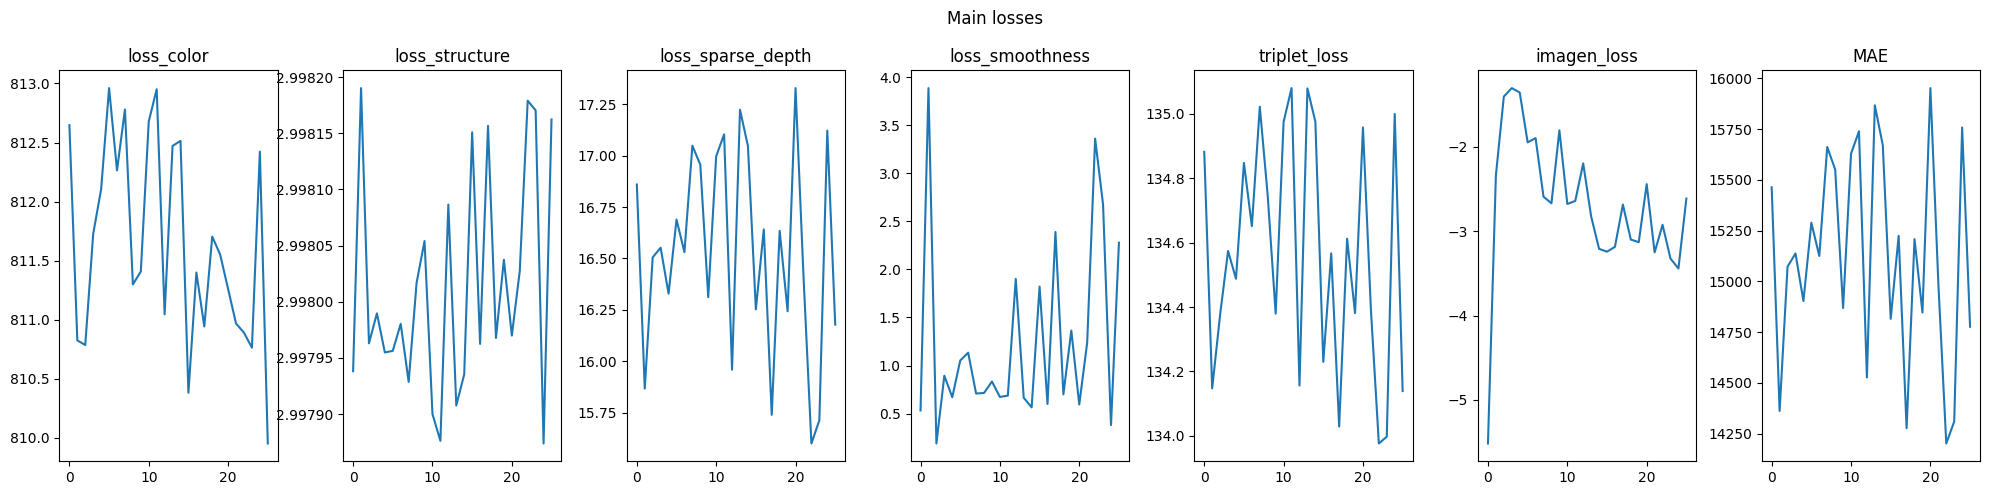

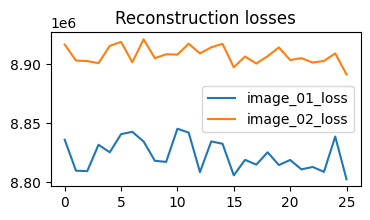

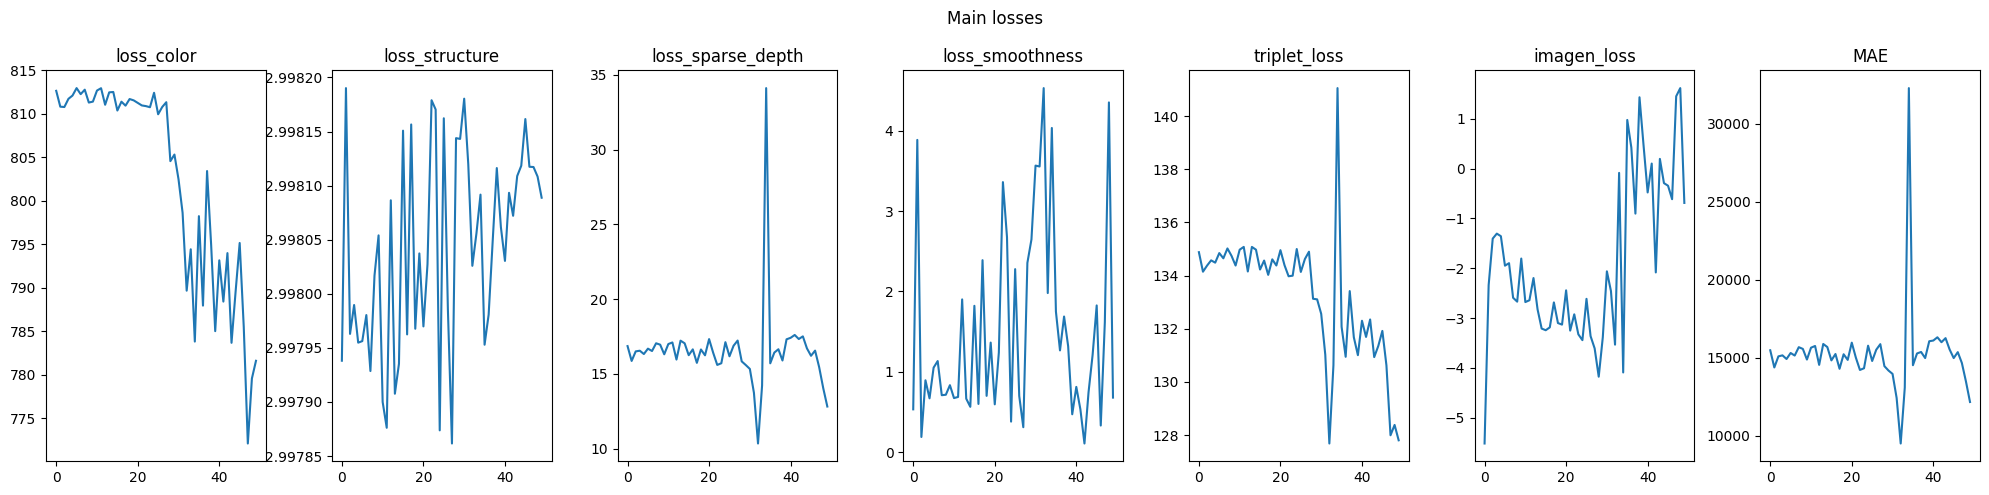

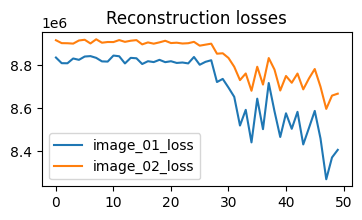

In [11]:
from rsl_depth_completion.conditional_diffusion.ssl_utils import (
    calc_error_to_gt,
    plot_losses,
)
from rsl_depth_completion.models.benchmarking.calibrated_backprojection_network.kbnet import (
    eval_utils,
)
from tqdm.auto import tqdm

global_step = 0
batch_size = train_dataloader.batch_size
unet_idx = 2
losses = []
rec_losses = {
    "image_01_loss": [],
    "image_02_loss": [],
}
losses = {
    "loss_color": [],
    "loss_structure": [],
    "loss_sparse_depth": [],
    "loss_smoothness": [],
    "triplet_loss": [],
    "imagen_loss": [],
    "MAE": [],
}
output_depths = []
parameters_pose_model = list(trainer.pose_model.parameters())
parameters_depth_model = list(trainer.parameters())
depth_grads = {k: [] for k in range(len(parameters_depth_model))}
pose_grads = {k: [] for k in range(len(parameters_pose_model))}

validity_map_depth = torch.where(
    eval_batch["sdm"] > 0, torch.ones_like(eval_batch["sdm"]), eval_batch["sdm"]
).bool()

num_epochs = 50
plot_epochs = [num_epochs // 2, num_epochs - 1]

progress_bar = tqdm(range(num_epochs), desc="Epoch")
for epoch in progress_bar:
    # progress_bar.set_description(f"Unet {unet_idx}\tEpoch {epoch}")
    images = eval_batch["input_img"]
    text_embeds = eval_batch["text_embed"]
    cond_images = eval_batch["cond_img"]

    forwards_kwargs = dict(
        images=images,
        text_embeds=text_embeds,
        cond_images=cond_images,
        unet_number=unet_idx,
        max_batch_size=cfg.max_batch_size,
        # use_max_times=True
    )

    adj_imgs = eval_batch["adj_imgs"]

    ssl_kwargs = dict(
        image0=eval_batch["rgb"],
        image1=adj_imgs[:, 0],
        image2=adj_imgs[:, 1],
        filtered_sparse_depth0=eval_batch["sdm"],
        filtered_validity_map_depth0=validity_map_depth,
        intrinsics=eval_batch["intrinsics"],
        rec_losses=rec_losses,
        losses=losses,
    )
    forwards_kwargs.update(ssl_kwargs)

    loss, output_depth = trainer(**forwards_kwargs)
    progress_bar.set_postfix(loss=loss)

    for i in range(len(parameters_depth_model)):
        if parameters_depth_model[i].grad is not None:
            depth_grads[i].append(
                torch.sum(torch.abs(parameters_depth_model[i].grad)).item()
            )
    for i in range(len(parameters_pose_model)):
        if parameters_pose_model[i].grad is not None:
            pose_grads[i].append(
                torch.sum(torch.abs(parameters_pose_model[i].grad)).item()
            )

    trainer.update(unet_number=unet_idx)

    mae = calc_error_to_gt(output_depth, eval_batch["gt"])
    losses["MAE"].append(mae.item())
    output_depths.append(output_depth)

    if epoch in plot_epochs:
        plot_losses(losses, rec_losses)

    # if epoch == 3:
    #     break

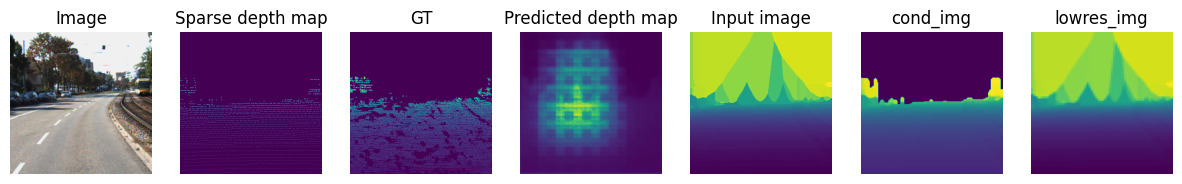

In [12]:
idx = -1
img, pred, sdm, gt, input_img, cond_img, lowres_img = (
    eval_batch["rgb"][idx],
    output_depths[idx][-1],
    eval_batch["sdm"][idx],
    eval_batch["gt"][idx],
    eval_batch["input_img"][idx],
    eval_batch["cond_img"][idx],
    eval_batch["lowres_img"][idx],
)
img = img.permute(1, 2, 0).cpu().numpy()
pred = pred.squeeze().cpu().detach().numpy()
sdm = sdm.squeeze().cpu().detach().numpy()
gt = gt.squeeze().cpu().detach().numpy()
input_img = input_img.permute(1, 2, 0).cpu().numpy()
cond_img = cond_img.permute(1, 2, 0).cpu().numpy()
lowres_img = lowres_img.permute(1, 2, 0).cpu().numpy()
fig, axs = plt.subplots(1, 7, figsize=(15, 5))
axs[0].imshow(img)
axs[1].imshow(sdm)
axs[2].imshow(gt.squeeze())
axs[3].imshow(pred)
axs[4].imshow(input_img)
axs[5].imshow(cond_img)
axs[6].imshow(lowres_img)
axs[0].set_title("Image")
axs[1].set_title("Sparse depth map")
axs[2].set_title("GT")
axs[3].set_title("Predicted depth map")
axs[4].set_title("Input image")
axs[5].set_title("cond_img")
axs[6].set_title("lowres_img")
for ax in axs:
    ax.axis("off")
plt.show()

/opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{0: [], 876: [1467.94482421875, 942.9993896484375, 878.8056640625, 454.8440856933594, 420.56146240234375, 595.993408203125, 1184.69189453125, 809.5584716796875, 1958.5645751953125, 590.6651000976562, 737.34912109375, 1370.3822021484375, 482.62567138671875, 784.955078125, 701.14599609375, 724.7716064453125, 652.6026611328125, 467.45977783203125, 619.7381591796875, 553.7257080078125, 1442.40234375, 651.74267578125, 537.12255859375, 531.91552734375, 955.7493896484375, 987.055419921875, 1090.179931640625, 666.3362426757812, 1273.9573974609375, 749.897705078125, 483.44354248046875, 2048.994873046875, 1308.816650390625, 1236.3746337890625, 17768.671875, 352.3670654296875, 409.5799560546875, 442.4577941894531, 2821.87060546875, 719.061279296875, 369.2540283203125, 588.8876953125, 902.7261352539062, 954.0327758789062, 1157.5770263671875, 1008.4542846679688, 1458.0771484375, 2019.66064453125, 6394.60302734375, 2576.30126953125], 76: [789.609130859375, 1105.4420166015625, 319.7217712402344, 405.

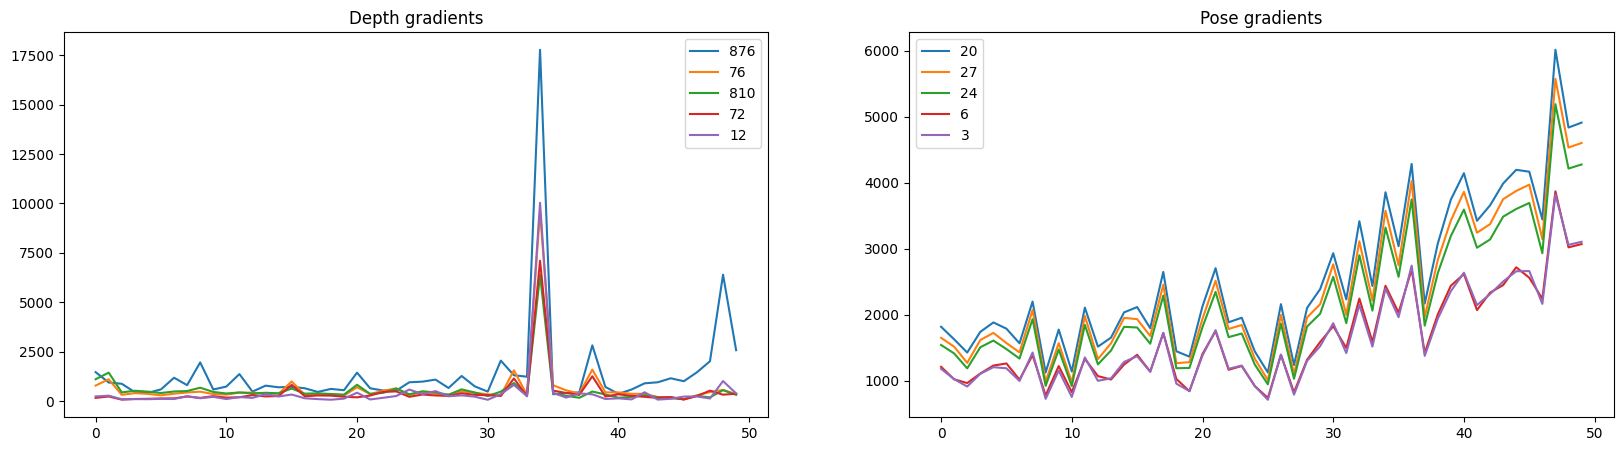

In [13]:
from rsl_depth_completion.conditional_diffusion.ssl_utils import plot_grads
plot_grads(depth_grads, pose_grads, topk=5, bottomk=None)
# plot_grads(depth_grads, pose_grads, topk=None, bottomk=5)

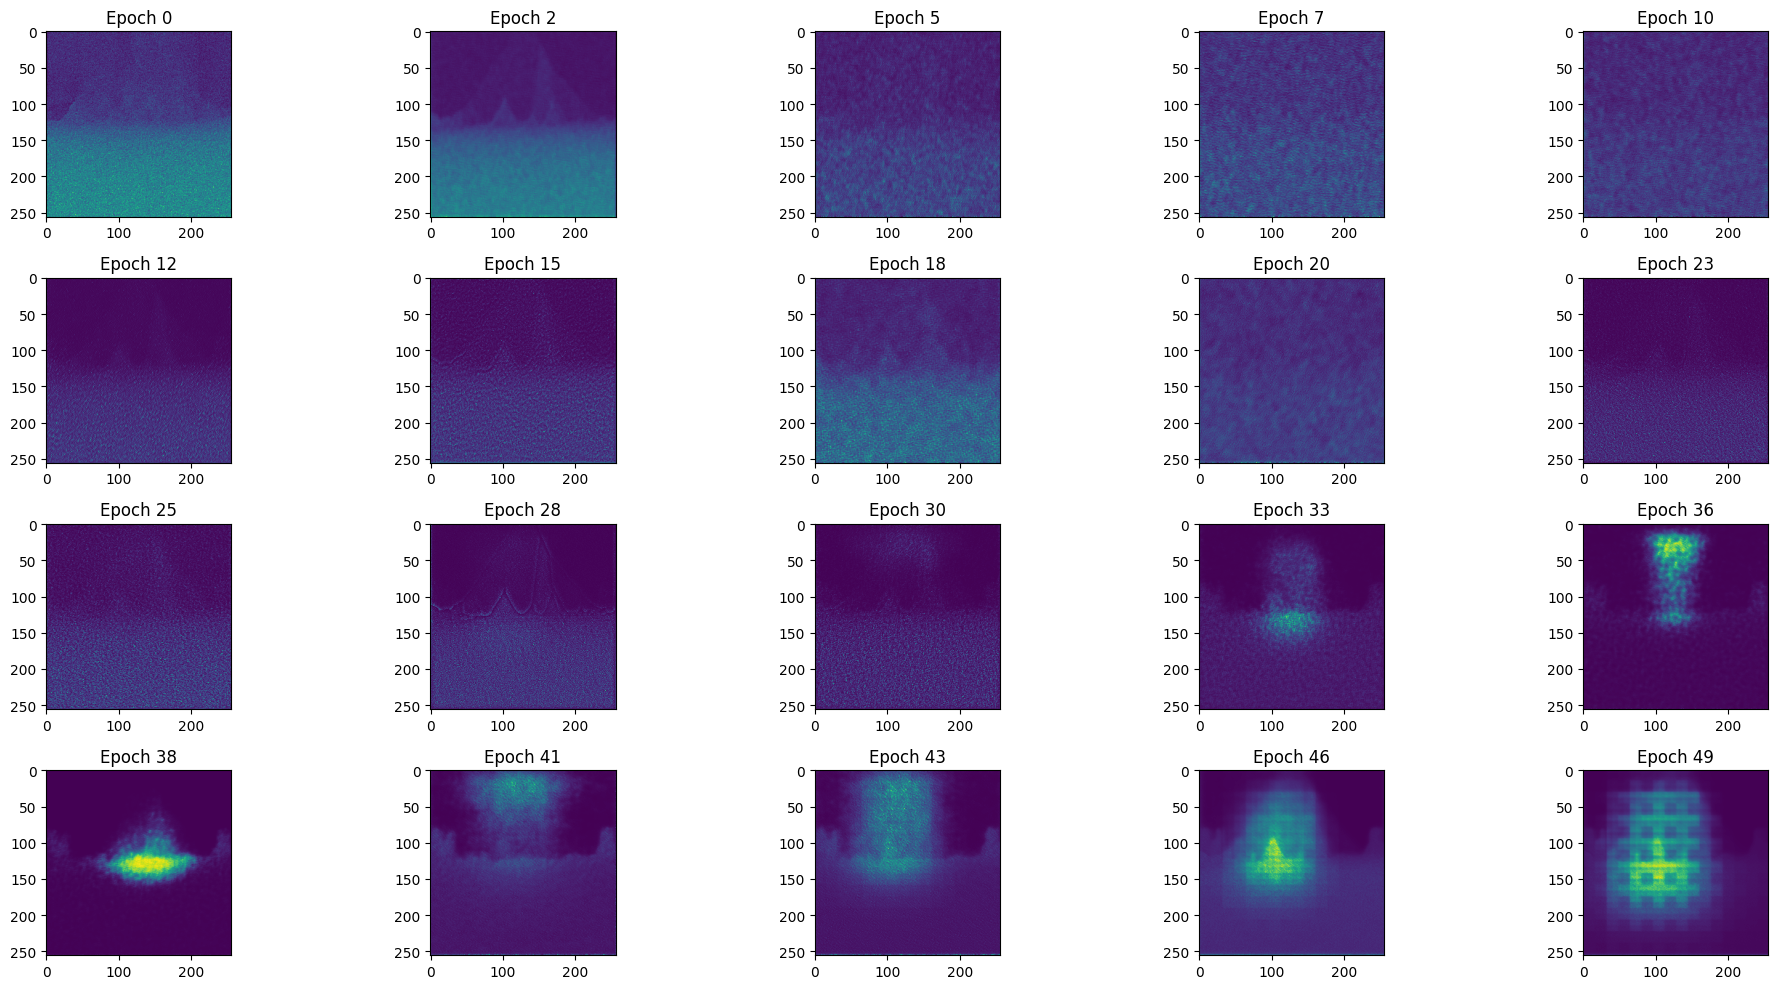

In [14]:
import numpy as np

pred_ckpts = np.linspace(0, len(output_depths)-1, 20).astype(int)
fig, axs = plt.subplots(len(pred_ckpts) // 5, 5, figsize=(20, 10))
for i, ckpt in enumerate(pred_ckpts):
    pred = output_depths[ckpt][-1].detach().cpu().numpy().squeeze()
    # pred = trainer.min_predict_depth / (
    #                 pred + trainer.min_predict_depth / trainer.max_predict_depth
    #             )
    axs[i // 5, i % 5].imshow(pred)
    axs[i // 5, i % 5].set_title(f"Epoch {ckpt}")
plt.tight_layout()
plt.show()

In [8]:
from rsl_depth_completion.conditional_diffusion.train_imagen_loop import sample
unet_idx=2
start_image_or_video = eval_batch['lowres_img']
samples_lowres = sample(
                        cfg,
                    trainer,
                    out_dir,
                    eval_batch,
                    1,
                    start_at_unet_number=unet_idx,
                    start_image_or_video=start_image_or_video,
                    stop_at_unet_number=unet_idx+1,
                    experiment=experiment,
)


unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

trained w/ ssl

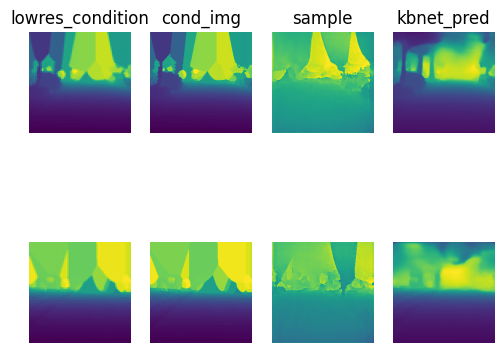

In [11]:
plot_sr_samples(samples_lowres[0], eval_batch, kbnet_preds=torch.load("./kbnet_eval_batch_preds.pt")[cfg.input_res])

trained w/o ssl

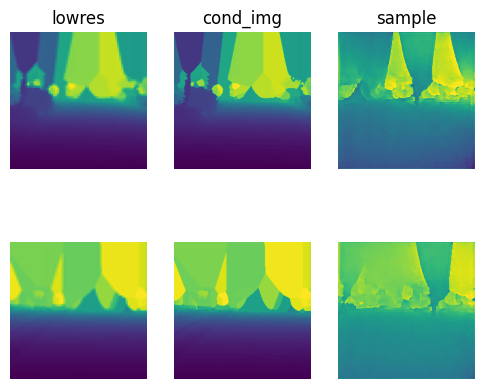

In [27]:
plot_sr_samples(samples_lowres[0], eval_batch)

In [ ]:
# from collections import defaultdict
# from functools import partial
# from kbnet.kbnet_model import KBNetModel

# from rsl_depth_completion.conditional_diffusion.custom_imagen_pytorch_ssl import exists
# from rsl_depth_completion.conditional_diffusion.custom_trainer_ssl import cast_torch_tensor, split_args_and_kwargs

# unet_number = trainer.validate_unet_number(unet_idx)
# trainer.validate_and_set_unet_being_trained(unet_number)
# trainer.set_accelerator_scaler(unet_number)

# assert (
#     not exists(trainer.only_train_unet_number)
#     or trainer.only_train_unet_number == unet_number
# ), f"you can only train unet #{trainer.only_train_unet_number}"

# total_loss = 0.0
# output_depths = []
# trainer.min_predict_depth = 1.5
# trainer.max_predict_depth = 100
# kwargs={**forwards_kwargs}
# rec_losses = kwargs.pop("rec_losses", defaultdict(lambda: list()))
# losses = kwargs.pop("losses", defaultdict(lambda: list()))

# kwargs.pop("max_batch_size")
# kwargs.pop("unet_number")

# @partial(cast_torch_tensor, cast_fp16=True)
# def forward(self, *args, unet_number=None, max_batch_size=None, **kwargs):
#     return trainer.imagen(
#                 *args,
#                 unet=trainer.unet_being_trained,
#                 unet_number=unet_number,
#                 **kwargs,
#             )
    
# trainer.pose_optimizer.zero_grad()
# for chunk_size_frac, (chunked_args, chunked_kwargs) in split_args_and_kwargs(
#     *[], split_size=1, **kwargs
# ):
#     with trainer.accelerator.autocast():
#         image0 = chunked_kwargs.pop("image0")
#         image1 = chunked_kwargs.pop("image1")
#         image2 = chunked_kwargs.pop("image2")
#         filtered_sparse_depth0 = chunked_kwargs.pop("filtered_sparse_depth0")
#         filtered_validity_map_depth0 = chunked_kwargs.pop(
#             "filtered_validity_map_depth0"
#         )
#         intrinsics = chunked_kwargs.pop("intrinsics").float()
#         pose01 = trainer.pose_model.forward(image0, image1)
#         pose02 = trainer.pose_model.forward(image0, image2)

#         imagen_loss, output_depth = forward(
#             trainer,
#             *chunked_args,
#             # unet=trainer.unet_being_trained,
#             unet_number=unet_number,
#             **chunked_kwargs,
#         )
#         output_depth0 = torch.sigmoid(output_depth)
#         output_depth0 = trainer.min_predict_depth / (
#             output_depth0 + trainer.min_predict_depth / trainer.max_predict_depth
#         )

#         # Compute loss function
#         triplet_loss, loss_info = KBNetModel.compute_loss(
#             image0=image0.cuda(),
#             image1=image1.cuda(),
#             image2=image2.cuda(),
#             output_depth0=output_depth0.cuda(),
#             sparse_depth0=filtered_sparse_depth0.cuda(),
#             validity_map_depth0=filtered_validity_map_depth0.cuda(),
#             intrinsics=intrinsics.cuda(),
#             pose01=pose01.cuda(),
#             pose02=pose02.cuda(),
#         )

#         loss = triplet_loss
#         # loss = imagen_loss
#         # loss = 0.3*imagen_loss + 0.7*triplet_loss

#         loss = loss * chunk_size_frac

#         image01 = loss_info['image01'].detach().cpu()
#         image02 = loss_info['image02'].detach().cpu()
#         image01_error_summary = torch.sum(
#             torch.mean(torch.abs(image0 - image01), dim=1, keepdim=False)
#         ).item()
#         image02_error_summary = torch.sum(
#             torch.mean(torch.abs(image0 - image02), dim=1, keepdim=False)
#         ).item()
#         # print("image01 reconstruction L1 loss: ", image01_error_summary)
#         # print("image02 reconstruction L1 loss: ", image02_error_summary)
#         rec_losses["image_01_loss"].append(image01_error_summary)
#         rec_losses["image_02_loss"].append(image02_error_summary)

#         loss_keys = [k for k in loss_info.keys() if "loss" in k]
#         for loss_key in loss_keys:
#             # print(f"{loss_key}: {loss_info[loss_key]}")
#             losses[loss_key].append(loss_info[loss_key].item())

#     output_depths.append(output_depth0.detach().cpu())
#     total_loss += loss.item()

#     if trainer.training:
#         trainer.accelerator.backward(loss)
#     print(trainer.pose_model.parameters()[0].grad)
#     print(next(trainer.parameters()).grad)
